# TDEM comparison with Commer and UBC

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook runs a comparison with the steel casing example included in [Commer et al. (2015)](https://doi.org/10.1190/geo2014-0324.1) (figure 14). Commer et al. (2015) compare finite difference (FD) and finite element codes (FE). We additionally include a comparison with the 3D finite volue UBC OcTree code. The SimPEG cylindrical mesh simulation also takes a finite volume approach. This notebook was used to produce Figures 3 and 4 in Heagy and Oldenburg (2018) 

We thank Michael Commer and Christoph Schwarzbach for providing the published and UBC results, respectively, and for permission to distribute them with this notebook. 

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them.

In [1]:
# !pip install -r ../requirements.txt

In [17]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
import os
import tarfile

import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

## Simulation parameters

In [18]:
simDir = 'TDEM_Commer_example'

In [19]:
sigma_air = 3e-4
sigma_back = 0.0333
sigma_casing = 1e6

outer_diameter = 135e-3  # 135 mm outer diameter
casing_t = 12e-3

mur_casing = 1.

dipole_l = 10. 
casing_l = 200 

csz = 2.5 

In [5]:
src_center = np.r_[50., 1.5*np.pi, -1.25] # make sure dipole is below surface
src_a = src_center + np.r_[dipole_l / 2., 0., 0.]
src_b = src_center - np.r_[dipole_l / 2., 0., 0.]

In [6]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = outer_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)

In [7]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

# or try more refined time-stepping
# timeSteps = [
#     (3e-10, 20), 
#     (1e-9, 20), (3e-9, 20), 
#     (1e-8, 20), (3e-8, 20),
#     (1e-7, 20), (3e-7, 20),
#     (1e-6, 20), 
#     (1e-5, 30), (3e-5, 30), 
#     (1e-4, 40), (3e-4, 30), 
#     (1e-3, 20), 
#     (1e-2, 17)
# ]


model.timeSteps = timeSteps
print(model.timeSteps.sum())
print(len(model.timeSteps))

0.20422
187


## Mesh

In [8]:
model.diffusion_distance(2e-1)

3091.7398727827467

In [9]:
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [10]:
dipole_l/4

2.5

In [11]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = dipole_l/4, # 4 cells across the length of the dipole
    domain_x = 300.,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 15,
    npadz = 16,
    csz = csz,
#     pfz = 1.5,
)

314272


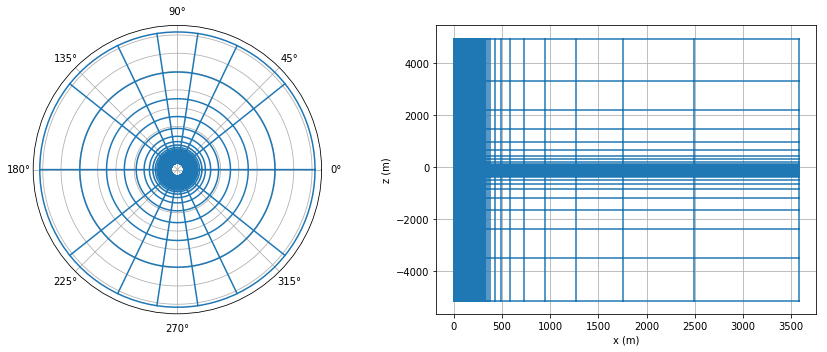

In [24]:
print(meshGen.mesh.nC)
ax = meshGen.mesh.plotGrid()
ax[0].set_yticklabels('')

ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('z (m)')

# plt.savefig('commer_mesh', dpi=350)
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

## Physical Properties

In [13]:
physprops = casingSim.model.PhysicalProperties(
    modelParameters=model,
    meshGenerator=meshGen
)

[(-300.0, 10.0), (-300.0, 10.0)]

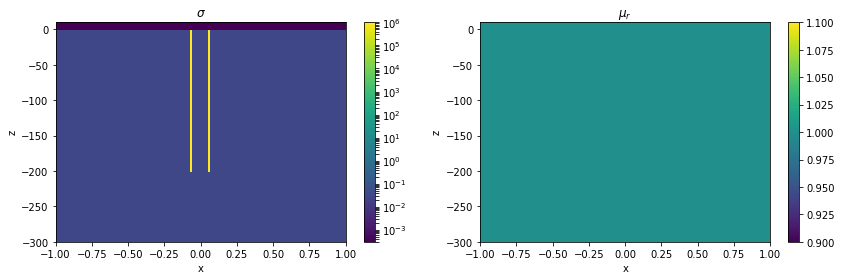

In [14]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-300., 10.]

ax = physprops.plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [15]:
src = casingSim.sources.HorizontalElectricDipole(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
)

(-10.0, 10.0)

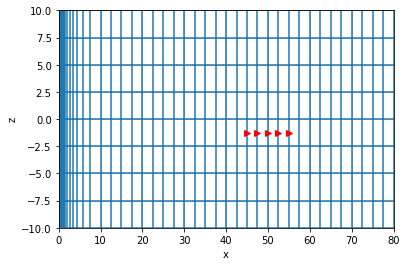

In [16]:
fig, ax = plt.subplots(1, 1)
meshGen.mesh.plotGrid(slice='theta', ax=ax)
src.plot(ax=ax)

ax.set_xlim([0., 80.])
ax.set_ylim([-10., 10.])

In [17]:
sim3D = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    src=src, 
)

## Run the simulation

uncomment the following cell to re-run the simulation (or save the simulation files and put those along with `simulation.py` on another machine if you want to run on a cluster) 


In [18]:
# sim3D.save()
# cwd = os.getcwd()
# os.chdir(cwd + os.path.sep + simDir)
# run "simulation.py"
# os.chdir(cwd)

# Load the results

In [19]:
f = "TDEM_Commer_example"
    
if not os.path.exists(f + os.path.sep + 'fields.npy'):
    download = Utils.download(
        "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
    )  
    tar = tarfile.open(download, "r:*")
    tar.extractall()
    tar.close()

In [20]:
# since the length of our source is 5 cells and each cell is 5m, and we used an input current of 1,
# we need to divide by (5/4) to have the same moment as Commer and UBC

moment_correction = 1.25

jx = np.load(simDir + os.path.sep + 'jx_compare.npy')/moment_correction
ex = np.load(simDir + os.path.sep + 'ex_compare.npy')/moment_correction
x_locs = np.load(simDir + os.path.sep + 'x.npy')

In [21]:
sim = casingSim.run.SimulationTDEM(
    directory=simDir,
    modelParameters=simDir + os.path.sep + 'ModelParameters.json',
    meshGenerator=simDir + os.path.sep + 'MeshParameters.json',
    src=simDir + os.path.sep + 'Source.json',
    fields_filename=simDir + os.path.sep + 'fields.npy'
)

In [22]:
np.unique(sim.prob.timeMesh.h)

array([  1.00000000e-06,   1.00000000e-05,   3.00000000e-05,
         1.00000000e-04,   3.00000000e-04,   1.00000000e-03,
         1.00000000e-02])

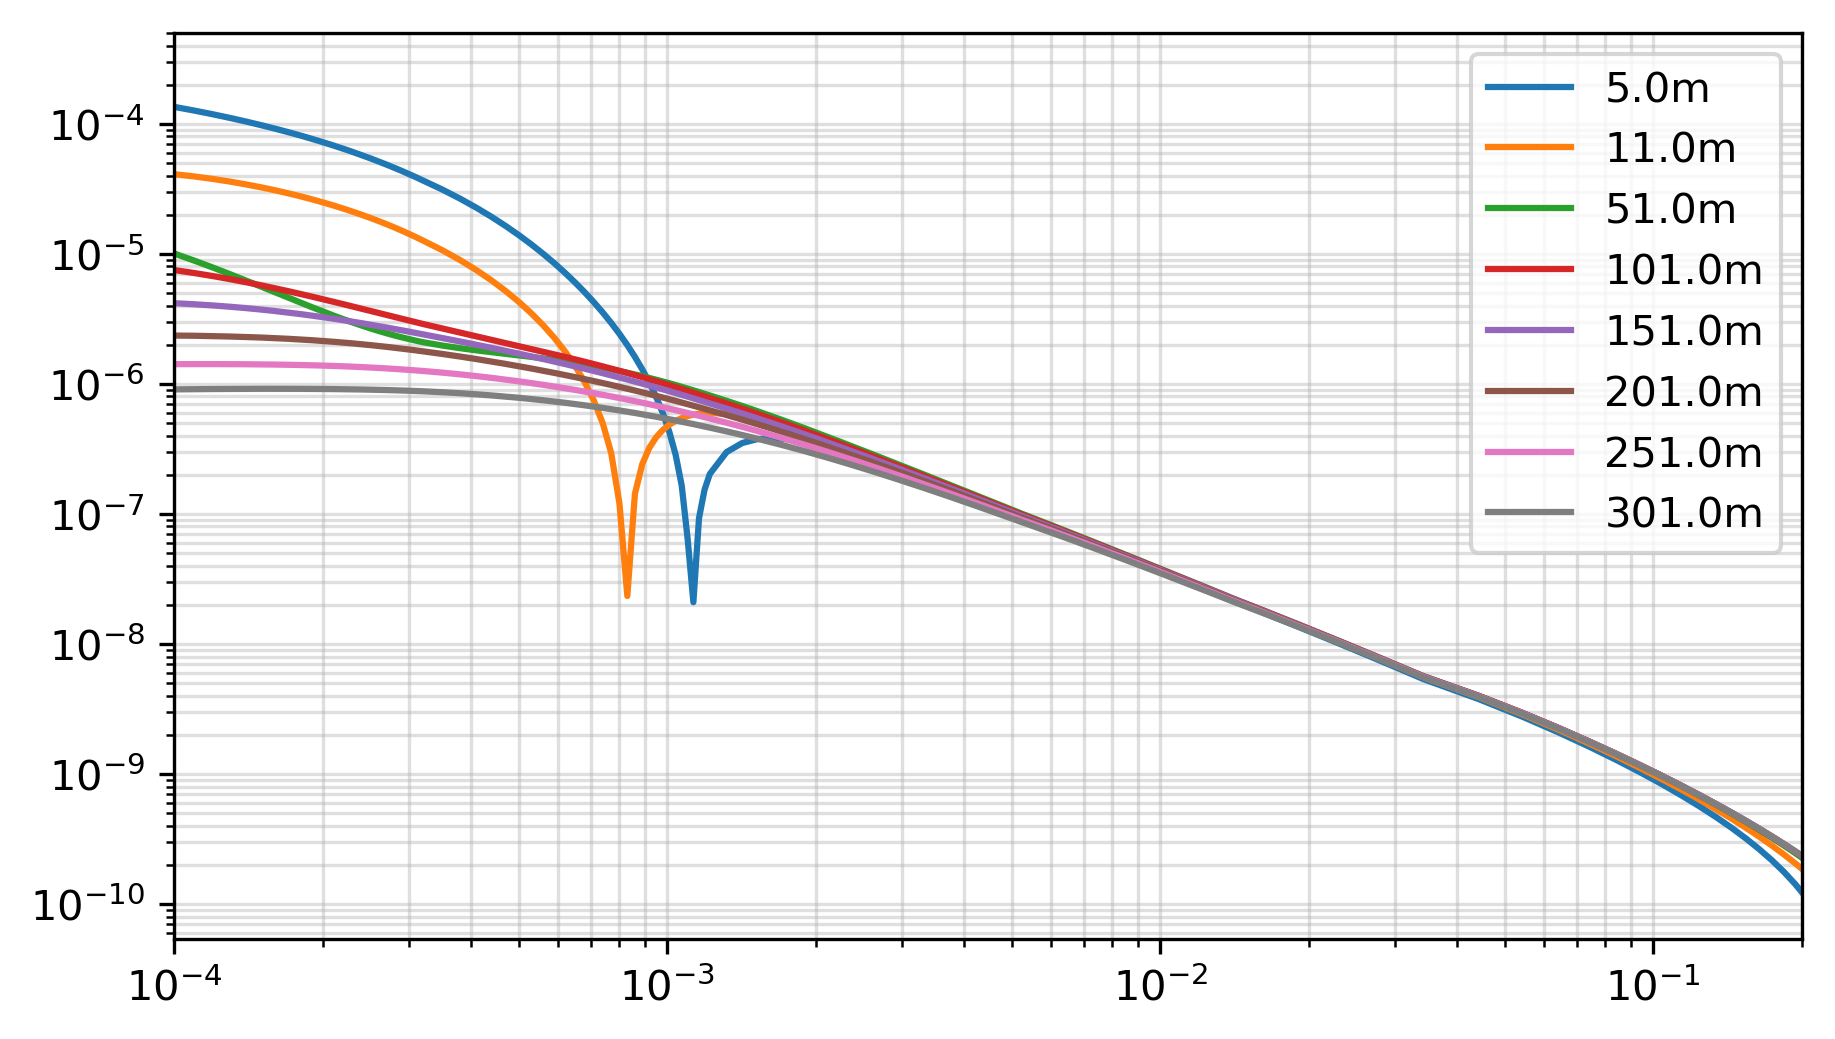

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)

for ind in range(ex.shape[0]):
    ax.loglog(sim3D.prob.times, np.abs(ex[ind, :]), label="{:1.1f}m".format(x_locs[ind]))
    ax.set_xlim(1e-4, 2e-1)
    ax.grid(which='both', alpha=0.4)
ax.legend()

# Load Commer results

In [24]:
commer_file = os.path.sep.join([simDir, 'CommerResults', 'fefd.data'])

f = open(commer_file)
lines = f.readlines()
f.close()

x_locs_commer = np.r_[5, 11, 51, 101, 151, 201, 251, 301]

In [25]:
commer_data = [l.rstrip() for l in lines if not l.startswith("#") ]
commer_dat = []

dat = []
for l in commer_data:
#     print(l)
    if l != '':
        dat.append(np.array(l.split(' ')).astype(float))
    elif l == '':
        if dat != []:
            commer_dat.append(np.vstack(dat))
            dat = []

# commer_data = dat

# Load UBC results

In [26]:
ubc_filename = os.path.sep.join([simDir, 'ubc_135mm_1e-2.txt'])
f = open(ubc_filename)
lines = f.readlines()
f.close()

In [27]:
ubc_data = [l.rstrip() for l in lines if not l.startswith("%") ]
x_locs_ubc = [4.8, 10.5, 100, 200, 300]

In [28]:
ubc_dat = []
dat = []
for l in ubc_data:
    if l != '':
        line = l.split(' ')
        line = [entry for entry in line if entry != '']
        dat.append(np.array(line).astype(float))
#         print(dat)

ubc_dat = np.vstack(dat)

# Plot Comparison

Text(0,0.5,u'radial E (V/m)')

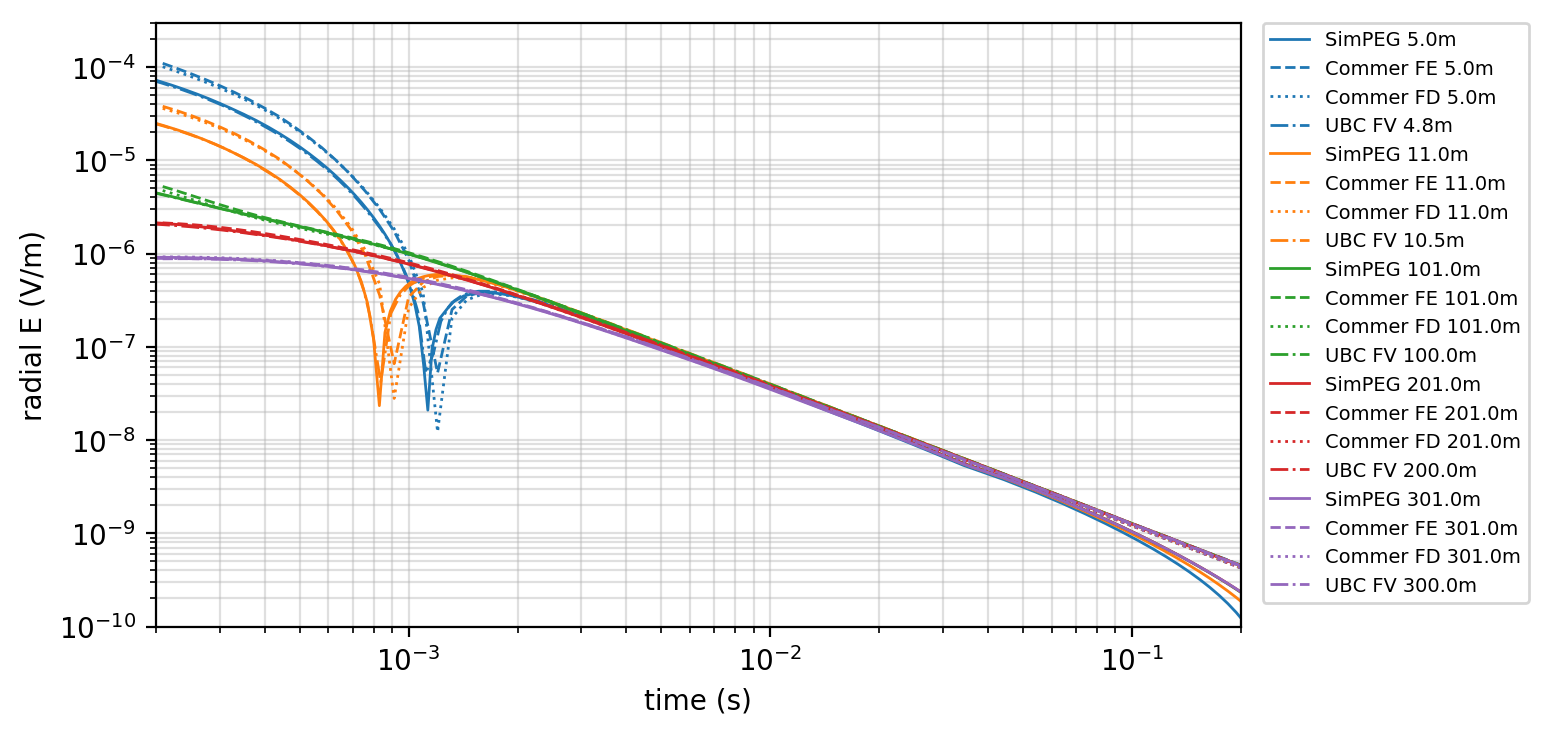

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=200)

inds_compare = [0, 1, 3, 5, 7]
for i, ind in enumerate(inds_compare):

    ax.loglog(
        sim3D.prob.times, np.abs(ex[ind, :]),
        "C{}".format(i), lw=1,
        label="SimPEG {:1.1f}m".format(x_locs[ind]),
    )
    ax.loglog(
        commer_dat[ind][:, 0], np.absolute(commer_dat[ind][:, 1]), "C{}--".format(i), lw=1,
        label="Commer FE {:1.1f}m".format(x_locs_commer[ind])
    )
    ax.loglog(
        commer_dat[ind][:, 0], np.absolute(commer_dat[ind][:, 2]), "C{}:".format(i), lw=1,
        label="Commer FD {:1.1f}m".format(x_locs_commer[ind])
    )
    ax.loglog(
        ubc_dat[:, 0], np.absolute(ubc_dat[:, i+1]), "C{}-.".format(i), lw=1,
        label="UBC FV {:1.1f}m".format(x_locs_ubc[i])
    )
    ax.set_xlim(2e-4, 2e-1)
    ax.set_ylim(1e-10, 3e-4)
    ax.grid(which='both', alpha=0.4)
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=7)
ax.set_xlabel('time (s)')
ax.set_ylabel('radial E (V/m)')

In [30]:
# fig.savefig('Commer_comparison')